> This notebook evalutes the performance of the output model from `ph_train.ipynb`

In [1]:
import os
import pickle

import geopandas as gp
import matplotlib.pyplot as plt
import pandas as pd
import yaml
from sklearn.metrics import r2_score

from povertymapping.utils.data_utils import (
    add_buffer_geom,
    compute_feat_by_adm,
    plot_feature_by_adm,
)

import subprocess


/home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/env/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Set Config

In [2]:
config = dict(
    save_path="../data/outputs/ph/model_ph/",
    repo_path="../data/SVII_PH_KH_MM_TL",
    download_gcs_uri="gs://poverty-mapping/outputs/",
    output_gcs_uri="gs://poverty-mapping/outputs/",
    data_dir="ph",
    country="ph",
    ookla_folder="ookla_ph",
    hdx_folder="hdx_ph",
    dhs_folder="dhs_ph",
    osm_folder="osm_ph",
    dhs_geo_zip_folder="PHGE71FL",
    dhs_zip_folder="PHHR71DT",
    viirs_folder="viirs_ph",
    traintest_folder="traintest_ph",
    crs="4683",
    # ookla_feature="avg_d_mbps",
    boundary_file="phl_adminboundaries_candidate_adm3",
    year="2020",
    quarter="2",
    sample=False,
    random_sample=False,
    no_samples=60,
    random_seed=42,
    # clust_rad=2000,
    # plot_ookla_features=True,
    adm_level=3,
    use_pcode=True,
    shape_label="ADM3_PCODE",
    bins=6,
    show_legend=False,
    use_ookla=True,
    use_viirs=True,
    use_osm=True,
    model_name='RF',
    # repo_dir: '/mnt/c/Users/MosesKim/Projects/unicef-ai4d-poverty-mapping-internal'
    # train test seed for reproducibility
    use_seed=True,
    train_test_seed=100,
    fix_random_state=False,
    # dc_run_hash=<dc_run_hash>
    # run_path: '/home/mosesckim/.virtualenvs/geo/.guild/runs'
    use_filt_clt=False,
    filt_clt='/mnt/c/Users/MosesKim/Projects/unicef-ai4d-poverty-mapping-internal/output/osm_roads.csv',
    # filt_filename: '<filt_filename>'
    pop_thresh=10,
    no_folds=3,
    train_test_split_prop=0.7,  # should coincide with number of folds, so automate
    run_da=False,
    da_class='KMM',
    use_buffer_geom=True,
    clust_rad=2000
)

## Download HDX boundaries

In [4]:
save_path = config['save_path']
hdx_gcs_uri = 'gs://poverty-mapping/SVII_PH_KH_MM_TL/ph/hdx_ph/phl_adminboundaries_candidate_adm3/'
subprocess.call([f'gsutil -m cp -n -r {hdx_gcs_uri} {save_path}'], shell=True)

Skipping existing item: file://../data/outputs/ph/model_ph/phl_adminboundaries_candidate_adm3/phl_admbnda_adm3_psa_namria_20200529.cpg
Skipping existing item: file://../data/outputs/ph/model_ph/phl_adminboundaries_candidate_adm3/phl_admbnda_adm3_psa_namria_20200529.dbf
Skipping existing item: file://../data/outputs/ph/model_ph/phl_adminboundaries_candidate_adm3/phl_admbnda_adm3_psa_namria_20200529.prj
Skipping existing item: file://../data/outputs/ph/model_ph/phl_adminboundaries_candidate_adm3/phl_admbnda_adm3_psa_namria_20200529.sbn
Skipping existing item: file://../data/outputs/ph/model_ph/phl_adminboundaries_candidate_adm3/phl_admbnda_adm3_psa_namria_20200529.sbx
Skipping existing item: file://../data/outputs/ph/model_ph/phl_adminboundaries_candidate_adm3/phl_admbnda_adm3_psa_namria_20200529.shp
Skipping existing item: file://../data/outputs/ph/model_ph/phl_adminboundaries_candidate_adm3/phl_admbnda_adm3_psa_namria_20200529.shp.xml
Skipping existing item: file://../data/outputs/ph/m

0

## Define helper functions

In [5]:
def compute_geom_and_mean(
    label, data_final, cluster_centroid_df, predictions=None, is_gt=True
):
    """Convert data feature/label into geo dataframe by cluster geometry"""
    # load all data
    if is_gt:
        result = data_final[
            ["DHSID", label]
        ]  # result should contain DHSID col and prediction col as above
    else:
        result = pd.DataFrame({"DHSID": data_final["DHSID"], label: predictions})
    # TODO: refactor and make below modular
    geometry_and_mean = gp.GeoDataFrame(
        pd.merge(cluster_centroid_df, result, on="DHSID", how="inner")
    )
    geometry_and_mean.crs = f"EPSG:{crs}"
    return geometry_and_mean

## Main evaluation script

In [6]:
features_path = '../data/outputs/ph/model_ph/PHGE71FL_test_features.pkl'
labels_path = '../data/outputs/ph/model_ph/PHGE71FL_test_labels.pkl'
hdx_path = '../data/outputs/ph/model_ph/phl_adminboundaries_candidate_adm3/phl_admbnda_adm3_psa_namria_20200529.shp'
cluster_coords_labels_path = "../data/outputs/ph/dhs_ph/PHHR71DT_PHGE71FL_by_cluster.csv"
data_final_path = '../data/outputs/ph/model_ph/traintest_ph/data_final.pkl'

Model chosen is: RF
Loading pickled files...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s remaining:   

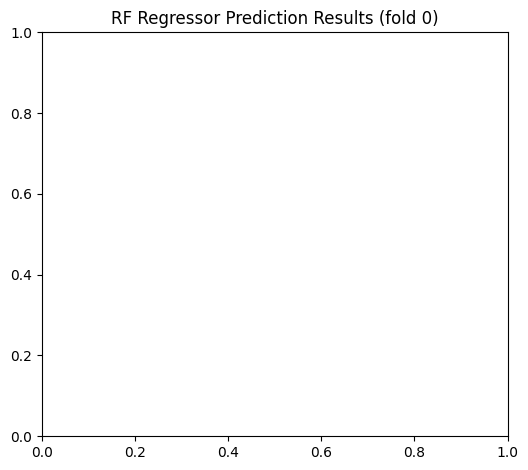

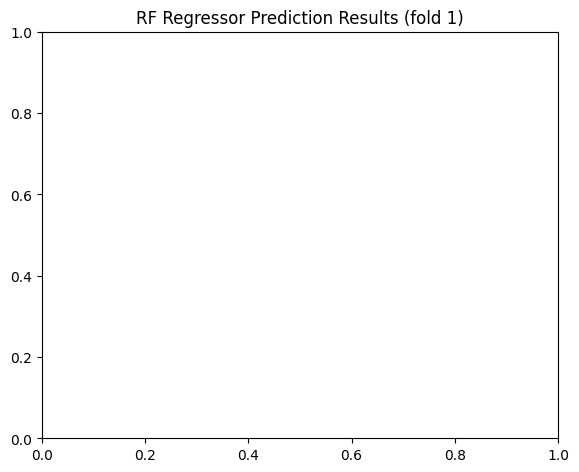

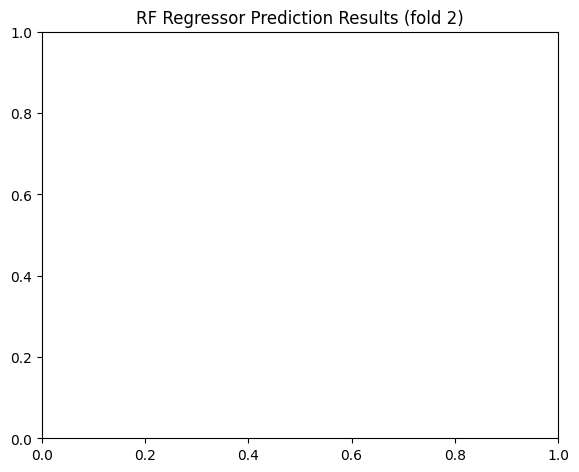

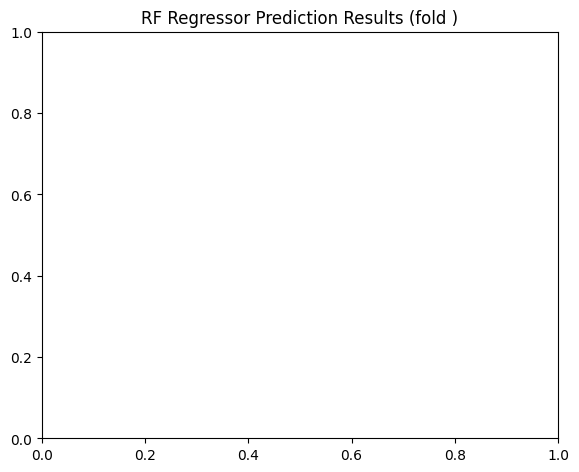

<Figure size 640x480 with 0 Axes>

In [9]:
%%time
# read in config
# config = yaml.safe_load(open("config.yml"))
model_name = config["model_name"]  # this is the class name

print(f"Model chosen is: {model_name}")

# no need to instantiate object
# we are not using TF, pytorch, etc.
# constructor =  getattr(models, model_name)

# load model pickle file
save_path = config["save_path"]
if model_name == "RF":
    model_path = os.path.join(save_path, "random_forest.pkl")
elif model_name == "XGB":
    model_path = os.path.join(save_path, "xgboost.pkl")
elif model_name == "LGBM":
    model_path = os.path.join(save_path, "light.pkl")
elif model_name == "LR":
    model_path = os.path.join(save_path, "lr.pkl")

with open(model_path, "rb") as file:
    model = pickle.load(file)

# # retrieve test features/labels
# dhs_geo_zip_folder = config["dhs_geo_zip_folder"]

# def path_map(x):
#     return os.path.join(save_path, f"{dhs_geo_zip_folder}_{x}.pkl")

# features_path, labels_path = list(map(path_map, ["test_features", "test_labels"]))

print("Loading pickled files...")
test_features, test_labels = list(
    map(lambda path: pd.read_pickle(path), [features_path, labels_path])
)

feature_names = test_features.columns
if model_name == "LR":
    features_dict = dict(zip(feature_names, model.coef_))
else:
    features_dict = dict(zip(feature_names, model.feature_importances_))


feat_imp_series = pd.Series(features_dict)

# extract top 20 important features
topn = 20
topn_features = feat_imp_series.sort_values(ascending=False).keys()[:20]

features_dict_red = {
    key: features_dict[key] for key in features_dict if key in topn_features
}

feat_imp_plot_series = pd.Series(features_dict_red).sort_values(ascending=True)
plt.title(f"{model_name} Regressor Feature Importance")
feat_imp_plot_series.plot.barh()

# TODO: call tight_layout for remaining plots
plt.tight_layout()
plt.savefig(os.path.join(save_path, f"{model_name}_feature_importance.jpeg"))
# clear figure before plotting next one
plt.clf()


predictions = model.predict(test_features)
ground_truth = test_labels

def plot_fold_scatter(model_name, ground_truth, predictions, fold_no, prefix=""):
    """Plot regression prediction scatter
    Args:
        model_name (str): model name
        ground_truth (array): array of values corresp. to gt
        predictions (array): array of values corresp. to preds
        fold_no (int): fold no.
        prefix (str, optional): plot filename prefix. Defaults to "".
    """
    plt.title(f"{model_name} Regressor Prediction Results (fold {fold_no})")

    fig, ax = plt.subplots(1,1)
    r2 = round(r2_score(ground_truth, predictions), 2)

    ax.set_xlabel("Ground Truth")
    ax.set_ylabel("Predictions")
    ax.scatter(ground_truth, predictions, label=f"R2={r2}")
    ax.legend(loc="upper left")
    ax.plot([0,1],[0,1], transform=ax.transAxes, color='r')
    plt.tight_layout()
    fig.savefig(
        os.path.join(
            save_path, f"{prefix}_{model_name}_preds_gt_fold{fold_no}.jpeg"
        )
    )
    # clear figure before plotting next one
    plt.clf()

def plot_cv(model_name, prefix=""):
    """Extract gt, pred pairs from pickle file
    Args:
        model_name (str): model name
        prefix (str, optional): model name prefix. Defaults to "".
    """

    if len(prefix) == 0:
        filename = "gt_pred_by_fold.pkl"
    else:
        filename = f"{prefix}_gt_pred_by_fold.pkl"

    with open(os.path.join(save_path, filename), "rb") as file:
        gt_pred_by_fold = pickle.load(file)

    for key in gt_pred_by_fold:
        gt = gt_pred_by_fold[key]["ground_truth"]
        pred = gt_pred_by_fold[key]["predictions"]

        plot_fold_scatter(model_name, gt, pred, key, prefix)

no_splits = config["no_folds"]
with open(os.path.join(save_path, "sp_folds_labels.pkl"), "rb") as file:
    sp_folds_labels = pickle.load(file)
for fold_no in range(no_splits):
    print(f"Fold {fold_no}")
    print("label fold splits are: ", sp_folds_labels[f"fold_{fold_no}"])
    print()

plot_cv(model_name)

# if config["run_da"]:
#     # plot domain adaptation results
#     plot_cv(model_name, prefix="da")

plot_fold_scatter(model_name, ground_truth, predictions, "", "CV")

# # # prediction visualization
# # # troubleshooting
# # repo_dir = config[
# #     "repo_dir"
# # ]  # '/mnt/c/Users/MosesKim/Projects/unicef-ai4d-poverty-mapping'
# # data_dir = os.path.join(repo_dir, config["data_dir"], config["hdx_folder"])

# boundary_file_path = hdx_path
# crs = config["crs"]

# ph_boundaries = gp.read_file(boundary_file_path).to_crs(crs)

# # find indices corresp. to train/test
# # TODO: streamline data extraction in model pipeline
# dhs_geo_zip_folder = config["dhs_geo_zip_folder"]
# # cluster_coords_filename = f"{dhs_geo_zip_folder}_cluster_coords"
# cluster_coords_filename = cluster_coords_labels_path

# cluster_centroid_df = pd.read_csv(
#     cluster_coords_filename
# )

# # add geometry column
# if config["use_buffer_geom"]:
#     add_buffer_geom(cluster_centroid_df, r=config["clust_rad"])
# else:
#     # convert to geodataframe
#     lons, lats = cluster_centroid_df["longitude"], cluster_centroid_df["latitude"]
#     cluster_centroid_df = gp.GeoDataFrame(
#         cluster_centroid_df, geometry=gp.points_from_xy(lons, lats)
#     )

# cluster_centroid_df.crs = f"EPSG:{crs}"


# # data_final = pd.read_pickle(os.path.join(save_path, "data_final.pkl"))
# data_final = pd.read_pickle(data_final_path)

# label = "Wealth Index"
# features_list = [label]
# feature_names = test_features.columns

# # GROUND TRUTH
# # Plot ground truth wealth index aggregated by adm region
# geometry_and_mean = compute_geom_and_mean(label, data_final, cluster_centroid_df)

# to_map_data_left = compute_feat_by_adm(
#     ph_boundaries, 
#     geometry_and_mean, 
#     # features_list, 
#     config
# )

# # Manually relabelling Wealth Index_x to Wealth Index
# # TODO: fix this in compute_feat_by_adm
# to_map_data_left['Wealth Index'] = to_map_data_left['Wealth Index_x']

# print("Plotting ground truth...")
# plot_feature_by_adm(to_map_data_left, config, label, "Asset Index", "scale", True)

# # PREDICTIONS
# # now plot predictions
# all_X = data_final[feature_names]
# all_predictions = model.predict(all_X)

# geometry_and_mean = compute_geom_and_mean(
#     label, data_final, cluster_centroid_df, all_predictions, False
# )

# to_map_data_left = compute_feat_by_adm(
#     ph_boundaries, 
#     geometry_and_mean, 
#     # features_list, 
#     config
# )
# # Manually relabelling Wealth Index_x to Wealth Index
# # TODO: fix this in compute_feat_by_adm
# to_map_data_left['Wealth Index'] = to_map_data_left['Wealth Index_x']

# print("Plotting predictions...")
# plot_feature_by_adm(
#     to_map_data_left,
#     config,
#     label,
#     "Asset Index",
#     "scale",
#     True,
#     plot_title="Predictions",
# )

In [ ]:
compute_feat_by_adm??

Signature: compute_feat_by_adm(boundaries_df, features_by_cluster, config)
Source:   
def compute_feat_by_adm(boundaries_df, features_by_cluster, config):
    """Return feature mean, grouping by adm level
    Args:
        boundaries_df (geopandas.GeoDataFrame): geo dataframe containing adm level boundary shapes
        features_by_cluster (geopandas.GeoDataFrame): geo dataframe containing cluster buffer shapes and features
        features_list (list): list of features to aggregate by adm level
    """
    crs = config["crs"]

    # TODO: save boundary shape by adm level and save as json before uploading to GCS
    #       then name using adm level subscripts

    adm_level = config["adm_level"]
    geometry_and_cluster_features = gp.sjoin(
        features_by_cluster, boundaries_df, how="inner", predicate="intersects"
    ).to_crs(crs)

    use_pcode = config["use_pcode"]
    if use_pcode:
        group_indices = [f"ADM{adm_level}_PCODE", f"ADM{adm_level}_EN"]
    else:
        group

In [ ]:
plot_feature_by_adm??

Signature:
plot_feature_by_adm(
    admin_data,
    config,
    col='avg_d_mbps_wt',
    leg_title='Mean download speed',
    unit='Mbps',
    display_cmap=False,
    plot_title='Ground Truth',
)
Source:   
def plot_feature_by_adm(
    admin_data,
    config,
    col="avg_d_mbps_wt",
    leg_title="Mean download speed",
    unit="Mbps",
    display_cmap=False,
    plot_title="Ground Truth",
):
    """Plot features grouping by adm level"""
    # calculate range
    feature_series = admin_data[col]
    left = feature_series.min()
    right = feature_series.max()

    bins = config["bins"]
    d = (right - left) / bins
    cuts = tuple([left + d * i for i in range(-1, bins)])
    # d = (right - left) / 5
    # cuts = tuple([left + d*i for i in range(-1,6)])
    labels = []
    labels.append("NA")
    # construct labels
    upper_cuts = cuts[1:]  # lol
    for i, _ in enumerate(upper_cuts):
        if i == bins - 1:
            break
        le = round(upper_cuts[i], 2)
        re = round(

In [ ]:
to_map_data_left

,ADM3_PCODE,geometry,ADM3_EN,DHSCLUST,Wealth Index_x,DHSYEAR,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,...,ADM1DHS,DHSREGCO,LATNUM,LONGNUM,ALT_GPS,ALT_DEM,Wealth Index_y,index_right,Shape_Leng,Shape_Area
0,PH175301000,"MULTIPOLYGON (((118.58201 9.37821, 118.58250 9...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PH175101000,"POLYGON ((120.58273 13.50342, 120.58281 13.503...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PH030801000,"POLYGON ((120.49737 14.75766, 120.49755 14.757...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PH021501000,"POLYGON ((121.43328 18.46824, 121.43375 18.468...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PH083701000,"MULTIPOLYGON (((125.02540 10.73615, 125.02538 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1642,PH097332000,"MULTIPOLYGON (((122.05555 6.87368, 122.05569 6...",Zamboanga City,1034.5,12692.218194,2017.0,NaN,NaN,NaN,NaN,...,9.0,9.0,6.979052,122.097602,9999.0,20.0,12692.218194,1642.0,4.719512,0.122560
1643,PH074625000,"POLYGON ((123.16929 9.23097, 123.18530 9.21913...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1644,PH034932000,"POLYGON ((120.79646 15.48628, 120.80146 15.481...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1645,PH063047000,"POLYGON ((122.63220 10.86011, 122.63713 10.858...",Zarraga,841.0,-18193.772727,2017.0,NaN,NaN,NaN,NaN,...,6.0,6.0,10.809517,122.661828,9999.0,5.0,-18193.772727,1645.0,0.439317,0.003161
